In [2]:
import numpy as np
import pandas as pd
import importlib
import data_loader
import gibbs_sampler
importlib.reload(data_loader)
importlib.reload(gibbs_sampler)
from data_loader import CountryDataLoader
from gibbs_sampler import HierarchicalGibbsSampler
from scipy.sparse import block_diag as sparse_block_diag


In [58]:
# Display the current working directory
print("Current working directory:", os.getcwd())

# Specify the path to the Parquet file
file_path = 'C:/Users/frede/Desktop/Bachelor Data/Train/gbr.parquet'

# Read the Parquet file
df = pd.read_parquet(file_path)

# Display the first few rows of the DataFrame
df.head()

Current working directory: c:\Users\frede\Desktop\Bachelor\src


,eom,gvkey,prc,ret_exc_lead1m,market_equity,div12m_me,chcsho_12m,eqnpo_12m,ret_1_0,ret_3_1,...,betadown_252d,bidaskhl_21d,corr_1260d,betabab_1260d,rmax5_rvol_21d,age,qmj_prof,qmj_safety,y,weight
0,19851231,1932,0.470852,0.079891,0.982063,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.970105,0.0,0.0,0.081021,1604.18250
1,19851231,1945,0.384155,-0.015440,0.907324,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.965620,0.0,0.0,-0.014309,1604.18250
2,19851231,2338,0.449925,-0.045202,0.560538,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.998505,0.0,0.0,-0.044072,409.17271
3,19851231,2410,0.835575,0.000516,0.997010,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.998505,0.0,0.0,0.001647,1604.18250
4,19851231,2411,0.162930,-0.046030,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.005979,0.0,0.0,-0.044899,1604.18250


In [11]:
file_path = 'C:/Users/frede/Desktop/Bachelor Data/Train'

loader = CountryDataLoader(
    data_path=file_path,
    standardize=False,
    countries=["dnk","bel","deu","nld","aut","swe","esp","gbr","fr","can"],  # or None for all
    mode="train"
)
features_to_drop = ["eom", "gvkey", "y", "weight"]

loader.load_data(split_date=None)  # or "2021-01-01" for pretraining
X_dict = {
    c: df.drop(columns=features_to_drop).to_numpy()
    for c, df in loader.get_data().items()
}

Y_dict = {
    c: df["y"].to_numpy()
    for c, df in loader.get_data().items()
}

# Stacked global matrices
X = np.vstack([X_dict[c] for c in X_dict])
Y = np.concatenate([Y_dict[c] for c in Y_dict])
Z = sparse_block_diag([X_dict[c] for c in X_dict]).tocsr()  # compress it


In [5]:
tau_theta_g_sq = 1.0  
alpha_sigma = 2.0
beta_sigma = 1.0
alpha_lambda = 2.0
beta_lambda = 1.0
wishart_prior_variance = 0.1               
p = X.shape[1]                             
Sigma = wishart_prior_variance * np.eye(p)
nu = p + 2                                


n_iter = 10000
burn_in = 1000


In [6]:
sampler = HierarchicalGibbsSampler(
    X_dict=X_dict,
    Y_dict=Y_dict,
    X=X,
    Y=Y,
    Z=Z,
    n_iter=n_iter,
    burn_in=burn_in,
    tau_theta_g_sq=tau_theta_g_sq,
    alpha_sigma=alpha_sigma,
    beta_sigma=beta_sigma,
    hyper_type="gamma",  # or "gamma"
    alpha_lambda=alpha_lambda,
    beta_lambda=beta_lambda,
    Sigma=Sigma,
    nu=nu
)

sampler.run()

100%|██████████| 10000/10000 [1:05:38<00:00,  2.54it/s]


In [7]:
theta_g_samples = sampler.get_posterior_samples()["theta_g"]
df_theta_g = pd.DataFrame(theta_g_samples)
theta_l_samples = sampler.get_posterior_samples()["theta_l"]
country_codes = sorted(sampler.X_dict.keys())

rows = []
for i, sample in enumerate(theta_l_samples):
    row = {"iteration": i}
    for c in country_codes:
        theta_c = sample[c]
        for j, val in enumerate(theta_c):
            row[f"{c}_feat{j}"] = val
    rows.append(row)

df_theta_l = pd.DataFrame(rows)

pd.DataFrame(sampler.sigma2_samples, columns=["sigma2"]).to_csv("sigma2_samples.csv", index=False)
df_theta_l.to_csv("theta_l_samples.csv", index=False)
df_theta_g.to_csv("theta_g_samples.csv", index=False)

In [3]:

df_theta_g = pd.read_csv("theta_g_samples.csv")
df_theta_l = pd.read_csv("theta_l_samples.csv")

df_theta_l.to_parquet("theta_l_samples.parquet")





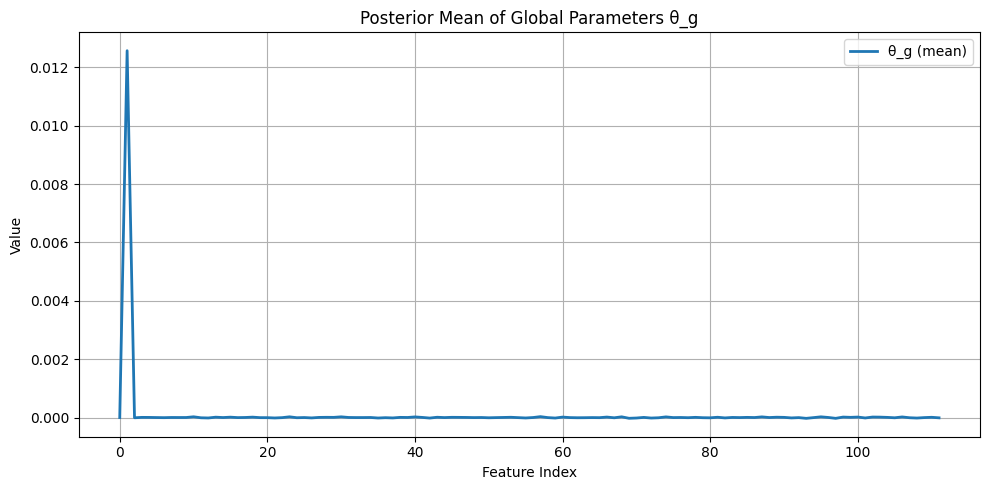

In [ ]:
import matplotlib.pyplot as plt
countries = sorted(set(col.split("_")[0] for col in df_theta_l.columns if "_" in col))
theta_g_mean = df_theta_g.mean().values

plt.figure(figsize=(10, 5))
plt.plot(theta_g_mean, label="θ_g (mean)", linewidth=2)
plt.title("Posterior Mean of Global Parameters θ_g")
plt.xlabel("Feature Index")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\frede\AppData\Local\Temp\ipykernel_8224\352141160.py:15: UserWarning: Glyph 119970 (\N{MATHEMATICAL SCRIPT CAPITAL G}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\frede\Desktop\Bachelor\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 119970 (\N{MATHEMATICAL SCRIPT CAPITAL G}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


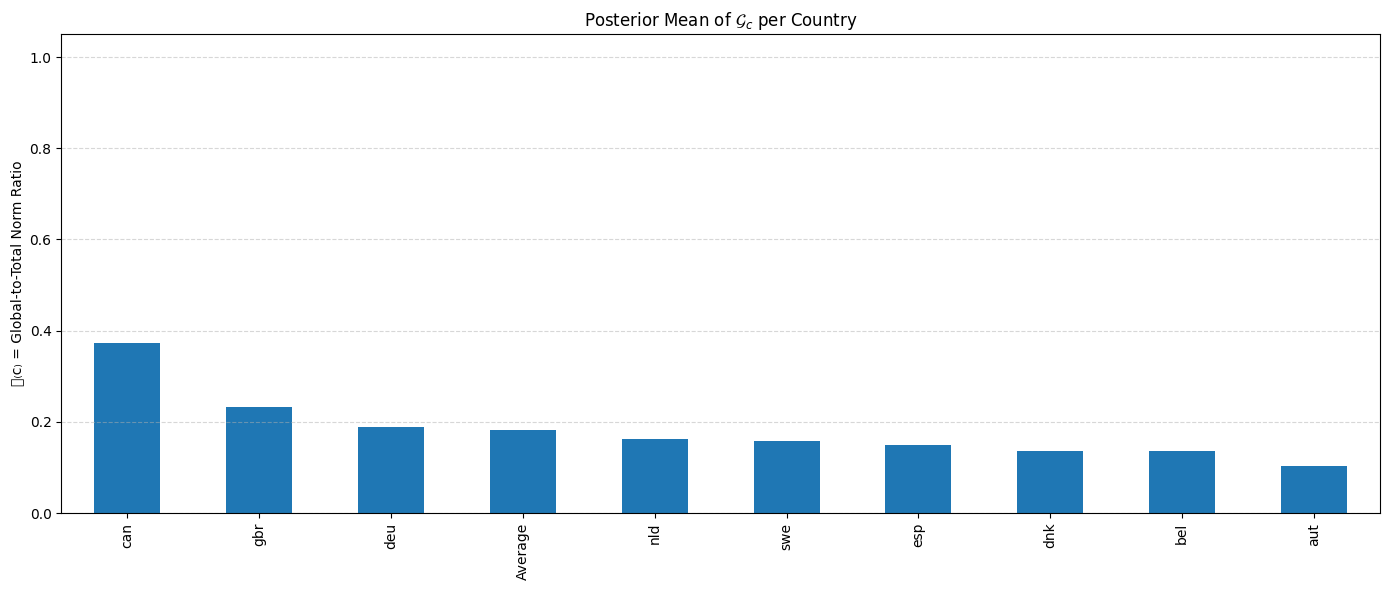

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Gc_mean = sampler.get_posterior_mean_Gc()
Gc_mean["Average"] = np.mean(list(Gc_mean.values()))

pd.Series(Gc_mean).sort_values(ascending=False).plot(kind="bar", figsize=(14, 6))
plt.title("Posterior Mean of $\\mathcal{G}_c$ per Country")
plt.ylabel("𝒢₍c₎ = Global-to-Total Norm Ratio")
plt.ylim(0, 1.05)
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()




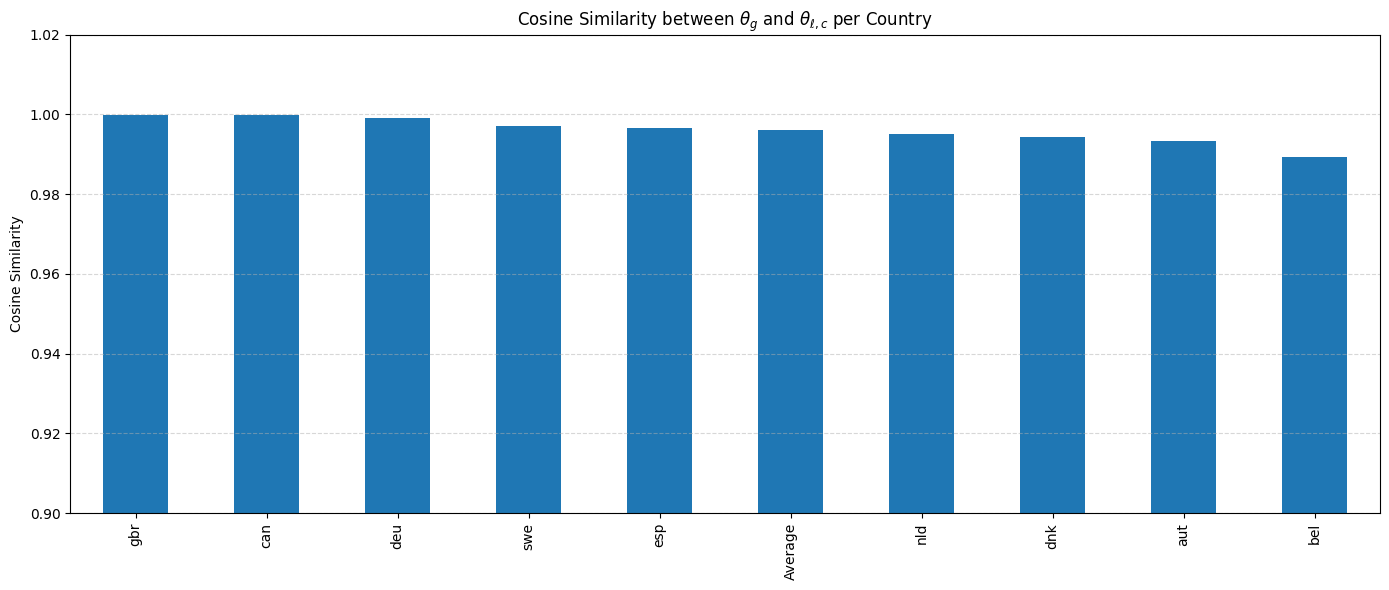

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

posterior = sampler.get_posterior_means()
theta_g = posterior["theta_g"]
theta_l = posterior["theta_l"]

cos_sim = {
    c: cosine_similarity(theta_g.reshape(1, -1), theta_l[c].reshape(1, -1))[0, 0]
    for c in theta_l
}

# Optional: Add average
cos_sim["Average"] = np.mean(list(cos_sim.values()))

# Plot
cos_sim_series = pd.Series(cos_sim).sort_values(ascending=False)

plt.figure(figsize=(14, 6))
cos_sim_series.plot(kind="bar")
plt.title("Cosine Similarity between $\\theta_g$ and $\\theta_{\\ell,c}$ per Country")
plt.ylabel("Cosine Similarity")
plt.xticks(rotation=90)
plt.ylim(0.9, 1.02)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
